In [1]:
import warnings
warnings.filterwarnings('ignore')

# Contents

* [Preprocess data](#preprocess)
* [Exclude trials/participants](#exclude)
* [Save finalized data](#save)

# Preprocess data <a class="anchor" id="preprocess"></a>

In [2]:
import matplotlib.pyplot as plt
import data_reader, data_analyser
import os
import seaborn as sns
import derivative_calculator

data_path = '../data/'
da = data_analyser.DataAnalyser()
dr = data_reader.DataReader()
index = ['subj_id', 'task', 'trial_no']
choices, dynamics = dr.read_data(data_path)

During data preprocessing, we calculate trajectory measures, etc. (TODO: provide brief description of what is done when we finalize pre-processing here, or move preprocessing to notebook)

## Preprocessing TODO's
* In dynamics dataframe, remove data points with negative y-velocity (see example trajectories in the end of this notebook)
* Add separate columns for x- and y-coordinates in a task-normalized coordinate frame (where $(0,0)$ is the average starting point across all participants in the task, and $(-1, y)$ and $(1, y)$ are the average end-points of the trajectories)
* Add a function which flips all trajectories so that LL response is always on the right and SS is on the left (see eyehandrdk for something similar)
* Add a function which time-normalizes the trajectories so that every trajectory has exactly n (e.g., n=101) data points (I think this was in data_reader.py we used for pilot data). This and the above functions will be needed for average trajectories and decision landscapes which we will include in exploratory analysis
* Separate pre-processing data and calculating measures (e.g., RT calculated based on trajectory duration should only be calculated after backwards movement is dropped)
* ...

## Only basic measures are added, without RT. There is a seperate function for adding RT and max-d: dr.get_RT(choices, dynamics)

In [3]:
choices = dr.add_basic_measures(choices)

# Calculate derivative

In [4]:
dc = derivative_calculator.DerivativeCalculator()        
dynamics = dc.append_derivatives(dynamics)

# Negative y-velocity detection

Backward movement detection. 

In [5]:
choices = dr.detect_backward_movement(choices,dynamics)


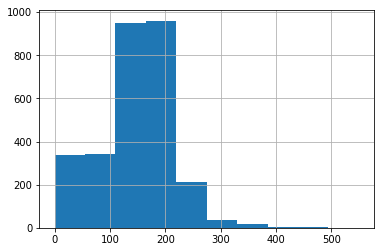

In [6]:
%matplotlib inline  
choices['first_backwards'].hist();

### Following line replaces y with nan if vy is negative.
### based on this, we could replace add a function that replaces nan in y column with a rolling mean?!

In [11]:
import numpy as np
dynamics2 = dynamics
dynamics2.loc[dynamics2['vy'] < 0]['y'] = np.nan

# Transform trajectories

Shift every trajectory so that on average they all start at (0,0)

In [12]:
dynamics = dr.transform_xy(dynamics)

# Resample trajectory
When needed, this function is now added to data_reader.py:

In [10]:
# dynamics = dr.apply_trajectory_resampling(dynamics)

# Flip trajectories

In [13]:
dynamics.loc[choices.option_chosen=='ss', ['x']] *= -1

In [14]:
print("Number of particpants: %i" % (len(choices)/(2*47)))

Number of particpants: 74


# Calculate RT

In [14]:
choices = dr.get_RT(choices,dynamics)

# Exclude trials/participants <a class="anchor" id="exclude"></a>

The idea is to have all data exclusion steps described in details in this notebook. However, if there is a potentially re-usable piece of code, it's better to put it in a py file (data_reader or data_analyser).

For every step of data exclusion, we might need to report how many trials/subjects were excluded and how we determined 

###  This join is needed for more convenient exploratory analysis/plotting of trajectories

In [15]:
dynamics = dynamics.join(choices.option_chosen)

## Excluding participants based on extreme discounting behavior

In [21]:
k_values, ip = da.get_k_values(choices, log=False)
extreme_k = k_values.loc[((k_values.mouse>0.98)&(k_values.walking>0.98)) | 
                         ((k_values.mouse<0.02)&(k_values.walking<0.02)), 'subj_id']

print("Number of excluded participants: %i" % (len(extreme_k)))
print(extreme_k.values)

choices = choices[~choices.index.get_level_values("subj_id").isin(extreme_k)]
dynamics = dynamics[~dynamics.index.get_level_values("subj_id").isin(extreme_k)]

Number of excluded participants: 14
[1095 1122 1282 1971 3846 4232 4550 4679 5389 5397 7095 7958 8767 9790]


## Excluding trials due to loss of data in the walking task

In [22]:
print("Data loss rate in walking trials: %f" % 
      (len(dynamics[(dynamics.task=='walking')&(dynamics.x.isna())])/len(dynamics[dynamics.task=='walking'])))

AttributeError: 'Series' object has no attribute 'isna'

In [ ]:
def get_data_loss_rate(trajectory):
    return len(trajectory[(trajectory.x.isna())])/len(trajectory)
data_loss_rate = dynamics.groupby(['subj_id', 'task', 'trial_no']).apply(get_data_loss_rate)

How many trials are there with more than, say, 20% data loss?

In [ ]:
print(data_loss_rate[data_loss_rate>0.2])

TODO: exclude these trials

## TODO

* Count and exclude trials with extreme RT (based on the distributions below, determine thresholds for outliers, the original thresholds from Stage 1 RR might not be optimal)
* Count and exclude trials with weird max-d (see negative values in the histograms below)
* Plot examples, count, and exclude walking trials with significant slowdowns ($\sqrt{v_x^2+v_y^2}<0.2 \textrm{m/s}$ somewhere in between y=1.5 and y=3.5)
* Count and exclude subjects who, after all exclusion of trials, have less than 38 trials left in either task ($47\times0.8 \approx 38$)
* ... (check the paper for other exclusion criteria )

## Exclusions based on RT and max-d

Response time distributions

(2, 15)

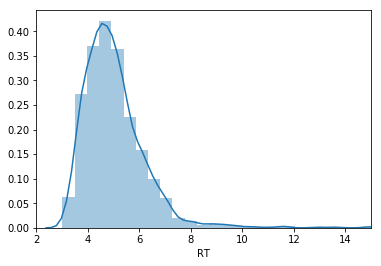

In [27]:
ax = sns.distplot(choices[choices.task=='walking'].RT)
ax.set_xlim(2,15)

(0, 15)

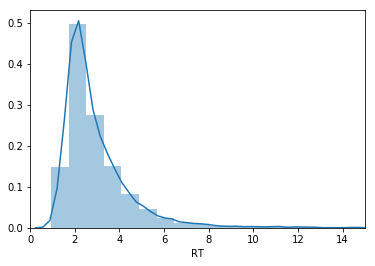

In [28]:
ax = sns.distplot(choices[choices.task=='mouse'].RT)
ax.set_xlim(0,15)

Max-d distributions

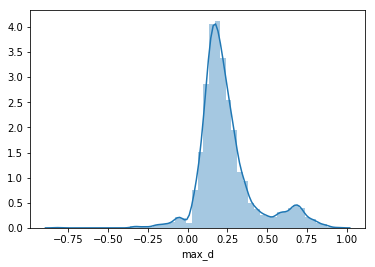

In [29]:
ax = sns.distplot(choices[choices.task=='mouse'].max_d)

This is obviously bimodal, TODO: run Hartigan's dip test (check out https://github.com/alimuldal/diptest). In addition, we obviously want to exclude trajectories with huge negative max-d

In [30]:
ax = sns.distplot(choices[(choices.task=='walking')&(~choices.max_d.isna())].max_d)

AttributeError: 'Series' object has no attribute 'isna'

Although I use np.nanmax() to calculate max-d, it's still nan in 4% of the walking trajectories. Probably, it has something to do with the basic algorithm of max-d calculation, which was not designed to handle missing data. 

In [31]:
len(choices[choices.max_d.isna()])/len(choices[choices.task=='walking'])

AttributeError: 'Series' object has no attribute 'isna'

TODO: investigate this, check some of these trajectories visually

However, if it's too complicated to handle those, we can just exclude them from Analysis 1 altogether

In [32]:
weird_trajectories = dynamics[choices.max_d.isna()]
da.plot_trajectories(weird_trajectories)

AttributeError: 'Series' object has no attribute 'isna'

## A few example trajectories

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


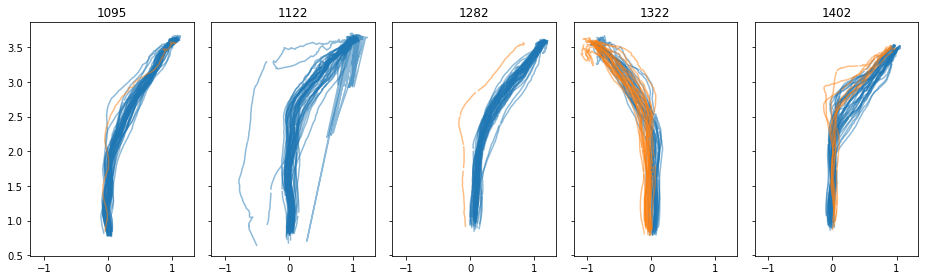

In [16]:
subjects = choices.subj_id.unique()

da.plot_trajectories_by_subject(dynamics[dynamics.task == 'walking'], subjects[0:5])

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


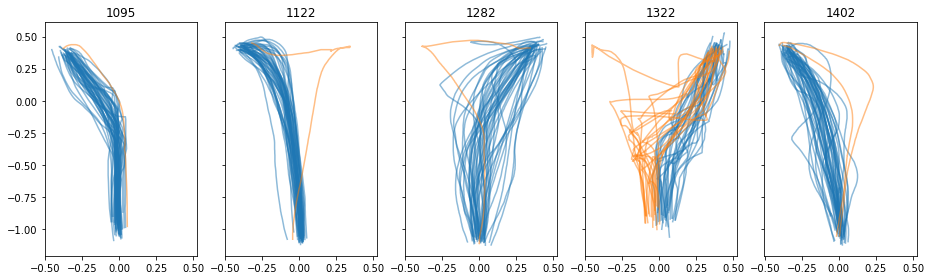

In [17]:
da.plot_trajectories_by_subject(dynamics[dynamics.task == 'mouse'], subjects[0:5])

# Saving finalized data <a class="anchor" id="save"></a>

In [ ]:
# saving preprocessed choices and dynamics for Analysis 1
choices.to_csv(os.path.join(data_path, 'choices_processed.txt'), index=False)
dynamics.to_csv(os.path.join(data_path, 'dynamics_processed.txt'), index=False)


# saving k-values for Analysis 2
k_values, ip = da.get_k_values(choices, log=False)
k_values_long = da.get_long_k_values(k_values, choices)

bias = da.get_ss_bias(data_path)
k_values_long = k_values_long.join(bias.set_index('subj_id'), on='subj_id')

k_values_long.to_csv(os.path.join(data_path, 'k_values.csv'), sep='\t', index=False)